### Imports

In [180]:
import numpy as np
import pandas as pd 
from collections import Counter
import os
import glob
import copy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib.lines import Line2D

### Read the ATN profiles 

In [181]:
gmm = pd.read_csv("../gmm/final_profiles_gmm.csv", index_col=0)
kmeans = pd.read_csv("../k_means/final_profiles_kmeans.csv", index_col=0)
tertile = pd.read_csv("../tertile/final_profiles_tertile.csv", index_col=0)
roc = pd.read_csv("../roc/final_profiles_roc.csv", index_col=0)
mean_sd = pd.read_csv("../mean_std/final_profiles_mean_std.csv", index_col=0)

In [182]:
mean_sd

,A-T-N-,A-T+N+,A-T-N+,A-T+N-,A+T+N-,A+T-N-,A+T-N+,A+T+N+
ADNI,813,154,20,22,0,7,0,1
EPAD,1165,49,9,4,0,10,0,0
PREVENT-AD,123,5,1,1,0,3,0,0
NACC,385,35,43,13,2,17,2,9
EMIF,742,117,70,33,1,31,15,5
DOD-ADNI,106,5,1,1,0,0,0,0
JADNI,119,48,8,4,3,10,1,4


In [183]:
patients_ = dict(gmm.sum(axis=1))

### Data preparation

In [184]:
# def normalize_atns(df):
#     'normalize the atn profiles'
    
#     for coh in df.index:
#         df.loc[coh] = (df.loc[coh]/sum(df.loc[coh]))
        

In [185]:
# normalize_atns(gmm)
# normalize_atns(kmeans)
# normalize_atns(tertile)
# normalize_atns(roc)
# normalize_atns(mean_sd)

In [186]:
gmm['method'] = 'gmm'
kmeans['method'] = 'kmeans'
tertile['method'] = 'tertile'
roc['method'] = 'roc'
mean_sd['method'] = 'mean_sd'

In [187]:
print(roc.index.difference(tertile.index))
roc.index # not all methods were applied for all cohorts

Index([], dtype='object')


Index(['ADNI', 'EPAD', 'NACC', 'EMIF', 'JADNI'], dtype='object')

In [188]:
profiles_all = pd.concat([gmm, kmeans, tertile, roc, mean_sd])

In [189]:
profiles_all.loc['ADNI']

,A-T-N-,A-T+N+,A-T-N+,A-T+N-,A+T+N-,A+T-N-,A+T-N+,A+T+N+,method
ADNI,275,28,5,2,25,443,12,227,gmm
ADNI,256,49,14,0,18,305,16,359,kmeans
ADNI,265,160,10,3,33,148,3,395,tertile
ADNI,304,147,8,6,34,180,1,337,roc
ADNI,813,154,20,22,0,7,0,1,mean_sd


In [190]:
atn_dict = dict()
for coh in profiles_all.index.unique():
    coh_prof = dict()
    
    for col in profiles_all.columns.difference(['method']):
        coh_prof[col] = profiles_all.loc[coh][col].to_list()
    
    atn_dict[coh] = coh_prof

In [191]:
def create_plot_input(my_dict):
    """transform input data into a list of tuples of form (middle, error)"""
    
    cohort_bars = dict()
    cohort_max_patient = dict()

    for coh in my_dict:
        bars = list()
        max_patient = list()
        atn_order = ['A-T-N-', 'A-T+N+', 'A-T-N+', 'A-T+N-', 'A+T+N-', 'A+T-N-', 'A+T-N+', 'A+T+N+']
        
        for prof in atn_order:
#             print(coh, prof, np.max(my_dict[coh][prof]))
            if np.max(my_dict[coh][prof]) != 0:
                # write the max value in a list
                max_patient.append(np.max(my_dict[coh][prof]))
                # normalize each value by the max participant within each category
                my_dict[coh][prof]= list(my_dict[coh][prof]/np.max(my_dict[coh][prof]))
                middle = ((np.max(my_dict[coh][prof]) - np.min(my_dict[coh][prof]))/2) + np.min(my_dict[coh][prof])
                err = (np.max(my_dict[coh][prof]) - np.min(my_dict[coh][prof]))/2         
    #             print(coh, middle, err)         
                bars.append((middle, err))
        
            else:
#                 print(coh)
                max_patient.append(0)
                bars.append((0, 0))

            # save the lists into dictionary for each respective cohort                                                       
            cohort_bars[coh] = bars
            cohort_max_patient[coh] = max_patient
            
                               
    return cohort_bars, cohort_max_patient

In [192]:
bars_dict, max_number = create_plot_input(atn_dict)

#### Printing and testing the results

In [193]:
profiles_all.loc['EPAD']

,A-T-N-,A-T+N+,A-T-N+,A-T+N-,A+T+N-,A+T-N-,A+T-N+,A+T+N+,method
EPAD,590,53,4,6,19,413,6,146,gmm
EPAD,503,121,28,2,22,277,7,277,kmeans
EPAD,621,167,24,6,24,169,5,221,tertile
EPAD,639,223,85,0,3,120,13,154,roc
EPAD,1165,49,9,4,0,10,0,0,mean_sd


In [194]:
profiles_all.loc['EPAD']['A+T-N-']

EPAD    413
EPAD    277
EPAD    169
EPAD    120
EPAD     10
Name: A+T-N-, dtype: int64

In [195]:
atn_dict['EPAD']['A+T-N-']

[1.0,
 0.6707021791767555,
 0.4092009685230024,
 0.29055690072639223,
 0.024213075060532687]

In [196]:
bars_dict['EPAD']

[(0.7158798283261802, 0.28412017167381975),
 (0.6098654708520179, 0.3901345291479821),
 (0.5235294117647058, 0.4764705882352941),
 (0.5, 0.5),
 (0.5, 0.5),
 (0.5121065375302664, 0.48789346246973364),
 (0.5, 0.5),
 (0.5, 0.5)]

In [197]:
bars_dict['PharmaCog']

[(0.9347826086956521, 0.06521739130434784),
 (0.6000000000000001, 0.4),
 (0.75, 0.25),
 (0, 0),
 (0.5555555555555556, 0.4444444444444444),
 (0.8059701492537313, 0.19402985074626866),
 (0.8, 0.2),
 (0.7674418604651163, 0.23255813953488375)]

In [198]:
# for x_pos, bar in enumerate(bars_dict['JADNI']):
#     print(x_pos, bar)

In [199]:
# for i in gmm.index: 
#     if i not in tertile.index.union(roc.index):
#         print(i)

In [200]:
tertile.index.difference(roc.index)

Index(['DOD-ADNI', 'PREVENT-AD'], dtype='object')

In [201]:
profiles_all.loc['PharmaCog']

,A-T-N-,A-T+N+,A-T-N+,A-T+N-,A+T+N-,A+T-N-,A+T-N+,A+T+N+,method
PharmaCog,46,1,2,0,1,67,5,23,gmm
PharmaCog,40,5,4,0,9,41,3,43,kmeans


In [202]:
max_number['ADNI']

[813, 160, 20, 22, 34, 443, 16, 395]

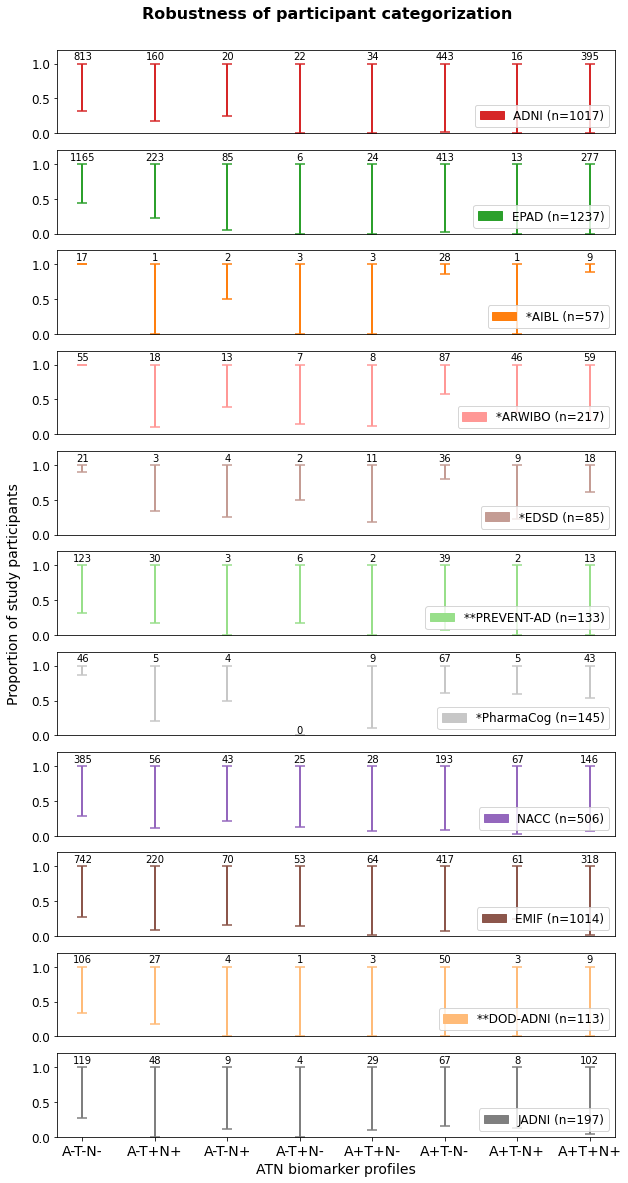

In [203]:
caps = 5
markersize = 4
capthick = 1.5
lw = 2
line_y = 0
subtitle_fontsize = 12
x_tick_alignment = "center"
x_tick_rotation = 0
# xlim = (-0.09,5)
colors = {'ADNI': '#d62728', 'AIBL': '#ff7f0e', 'EPAD': '#2ca02c', 
          'NACC': '#9467bd', 'EMIF': '#8c564b', 'JADNI': '#7f7f7f', 
          'DOD-ADNI': '#ffbb78', 'PREVENT-AD': '#98df8a', 'ARWIBO': '#ff9896', 
          'EDSD': '#c49c94', 'PharmaCog': '#c7c7c7'}

fig, axes = plt.subplots(11, 1, sharey=True, figsize=(10, 20))
fig.suptitle(f"Robustness of participant categorization", weight="bold", ha="center", fontsize=16, y=.91)

for i, coh in enumerate(bars_dict):
    for x_pos, bar in enumerate(bars_dict[coh]):
        my_bar = axes[i].errorbar(y=bar[0], x=x_pos, yerr=(bar[1]), capsize=caps, marker="", 
                         linestyle="", color=colors[coh], 
                         markersize=markersize, capthick=capthick, lw=lw)
        axes[i].set_xticks([])
        axes[i].tick_params(axis="x", which='major', labelsize=14)
        axes[i].tick_params(axis="y", which='major', labelsize=12)
        axes[i].set_ylim([0, 1.2])
#         axes[i].set_title(f"{coh}", loc="center", fontsize=subtitle_fontsize)

        axes[i].text(x_pos, 1.03*(bar[0] + bar[1]), max_number[coh][x_pos], ha='center', va='bottom')

        
        if coh not in tertile.index.union(roc.index):
            axes[i].legend(handles=[mpatches.Patch(color=colors[coh], label=f"*{coh} (n={patients_[coh]})")], loc="lower right", fontsize=12)
        
        elif coh in tertile.index.difference(roc.index):
            axes[i].legend(handles=[mpatches.Patch(color=colors[coh], label=f"**{coh} (n={patients_[coh]})")], loc="lower right", fontsize=12)

        else:
            axes[i].legend(handles=[mpatches.Patch(color=colors[coh], label=f"{coh} (n={patients_[coh]})")], loc="lower right", fontsize=12)

    
axes[10].set_xticks(list(range(8)))
axes[10].set_xticklabels(labels=['A-T-N-', 'A-T+N+', 'A-T-N+', 'A-T+N-', 'A+T+N-', 'A+T-N-', 'A+T-N+', 'A+T+N+'], ha=x_tick_alignment, fontsize=14)
axes[10].set_xlabel('ATN biomarker profiles', fontsize=14)
axes[5].set_ylabel('Proportion of study participants', fontsize=14, labelpad=10)


# plt.tight_layout()
plt.savefig("profiles_test.png", dpi=400, bbox_inches='tight')

### Stackedplot

In [204]:
profiles_all.replace({'mean_sd': 'Mean ±2 SD', 'gmm': 'GMM', 
                              'roc': 'ROC', 'kmeans': 'K-Means', 
                              'tertile': 'Tertile'}, inplace=True)

In [205]:
# fig, axes = plt.subplots(11, sharex=True, figsize=(8, 28))
# fig.subplots_adjust(hspace=0.3)

# # colors_ = ['#00a9b5', '#008ac5', '#0069c0', '#0045a5', '#0b1d78']
# colors_ = ['#F7EC09', '#3EC70B', '#3B44F6', '#A149FA', '#FF7396']

# for i, coh in enumerate(profiles_all.index.unique()):
#     current_cohort_ = profiles_all.loc[coh].copy()
#     current_cohort_['Cohort'] = coh
# #     print(current_cohort_)
#     current_cohort_.set_index('method', inplace=True)
#     if i!=0:
#         current_cohort_.transpose().iloc[:-1].plot(kind='bar', stacked=True, ax=axes[i] , color=colors_, legend=False)
#         axes[i].set_title(coh, fontsize=14, pad=10)
#         axes[i].tick_params(axis="x", which='major', labelsize=14)


#     else:
#         current_cohort_.transpose().iloc[:-1].plot(kind='bar', stacked=True, ax=axes[i] , color=colors_)
#         axes[i].set_title(coh, fontsize=14, pad=10)
# #         axes[i].tick_params(axis="x", which='major', labelsize=14)
        

# plt.savefig("stacked_bar_atn.png", dpi=300, bbox_inches='tight')

In [206]:
# fig, axes = plt.subplots(11, sharex=True, figsize=(10, 28))
# fig.subplots_adjust(hspace=0.25)
# width = {'2': .3, '4': 0.6, '5': .75}
# colors_ = ['#EC9CD3', '#FF7F3F', '#FBDF07', '#89CFFD', '#6ECB63']
# # colors_ = ['#89CFFD', '#008ac5', '#0069c0', '#0045a5', '#0b1d78']
# colors_dict = {method: color for color, method in zip(colors_, profiles_all.method.unique())}

# # colors_ = sns.color_palette('Paired', n_colors=5)
# # colors_ = ['#EC9CD3', '#FF7F3F', '#FBDF07', '#89CFFD', '#6ECB63']

# for i, coh in enumerate(profiles_all.index.unique()):
#     current_cohort_ = profiles_all.loc[coh].copy()
#     current_cohort_['Cohort'] = coh
#     current_cohort_.rename(columns={'method': 'Method'}, inplace=True)
#     current_cohort_.set_index('Method', inplace=True)
#     current_cohort_ = current_cohort_.transpose()
# #     print(current_cohort_)
#     for ind in current_cohort_.index[:-1]:
#         current_cohort_.loc[ind, 'delta'] = (max(current_cohort_.loc[ind]) - min(current_cohort_.loc[ind]))
# #         current_cohort_.loc[ind, 'error'] = (max(current_cohort_.loc[ind]) - min(current_cohort_.loc[ind]))/2
# #         current_cohort_.loc[ind, 'middle'] = ((max(current_cohort_.loc[ind]) - min(current_cohort_.loc[ind]))/2) + min(current_cohort_.loc[ind])
    
    
#     if i!=0:
#         for x_pos, indd in enumerate(current_cohort_.index[:-1]):            
# #             axes[i].errorbar(y=current_cohort_.loc[indd, 'middle'], x=x_pos, yerr=current_cohort_.loc[indd, 'error'], capsize=caps, marker="", 
# #                              linestyle="", color='black', markersize=markersize, capthick=capthick, lw=lw)
#             if len(current_cohort_.columns[:-1])==5:
#                 axes[i].text(x_pos, 1.2*(current_cohort_.loc[indd, current_cohort_.columns[2]]), int(current_cohort_.loc[indd, 'delta']), ha='center', va='bottom')
            
#             elif len(current_cohort_.columns[:-1])==2:
#                 axes[i].text(x_pos, 1.2*(max(current_cohort_.loc[indd][:-1])), int(current_cohort_.loc[indd, 'delta']), ha='center', va='bottom')
                
#             else:
#                 axes[i].text(x_pos, 1.2*(((current_cohort_.loc[indd, current_cohort_.columns[1]] + current_cohort_.loc[indd, current_cohort_.columns[2]]))/2), int(current_cohort_.loc[indd, 'delta']), ha='center', va='bottom')

    
#         current_cohort_[current_cohort_.columns[:-1]].iloc[:-1].plot(kind='bar', ax=axes[i], color=colors_dict, legend=False, 
#                                        width=width[str(len(current_cohort_.columns[:-1]))])
#         axes[i].set_title(coh, fontsize=14, pad=10)
#         axes[i].tick_params(rotation=0, axis="x", which='major', labelsize=14)
# #         axes[i].text(x_pos, 1.10*(bar[0] + bar[1]), max_number[coh][x_pos], ha='center', va='bottom')

#     else:
#         for x_pos, indd in enumerate(current_cohort_.index[:-1]):
# #             axes[i].errorbar(y=current_cohort_.loc[indd, 'middle'], x=x_pos, yerr=current_cohort_.loc[indd, 'error'], capsize=caps, marker="", 
# #                          linestyle="", color='black', markersize=markersize, capthick=capthick, lw=lw)
#             if len(current_cohort_.columns[:-1])==5:
#                 axes[i].text(x_pos, 1.2*(current_cohort_.loc[indd, current_cohort_.columns[2]]), int(current_cohort_.loc[indd, 'delta']), ha='center', va='bottom')
            
#             elif len(current_cohort_.columns[:-1])==2:
#                 axes[i].text(x_pos, 1.2*(max(current_cohort_.loc[indd][:-1])), int(current_cohort_.loc[indd, 'delta']), ha='center', va='bottom')
                
#             else:
#                 axes[i].text(x_pos, 1.2*(((current_cohort_.loc[indd, current_cohort_.columns[1]] + current_cohort_.loc[indd, current_cohort_.columns[2]]))/2), int(current_cohort_.loc[indd, 'delta']), ha='center', va='bottom')

#         current_cohort_[current_cohort_.columns[:-1]].iloc[:-1].plot(kind='bar', ax=axes[i], color=colors_dict, 
#                                                    width=width[str(len(current_cohort_.columns[:-1]))])
#         axes[i].set_title(coh, fontsize=14, pad=10)
#         axes[i].legend(loc='upper center')
# #         axes[i].tick_params(axis="x", which='major', labelsize=14)
        

# plt.savefig("bar_atn_witherror.png", dpi=300, bbox_inches='tight')

In [211]:
# fig, axes = plt.subplots(11, sharex=True, figsize=(10, 28))
# fig.subplots_adjust(hspace=0.25)
# width = {'2': .3, '4': 0.6, '5': .75}
# # colors_ = ['#EC9CD3', '#FF7F3F', '#FBDF07', '#89CFFD', '#6ECB63']
# # colors_ = ['#483838', '#42855B', '#90B77D', '#D2D79F', ]
# # colors_ = ['#C8C6A7', '#92967D', '#BBBBBB', '#6E7C7C', '#435560']
# # colors_ = ['#ff7f0e', '#2ca02c', '#7f7f7f', '#ff9896', '#c49c94']
# # colors_ = ['#89CFFD', '#008ac5', '#0069c0', '#0045a5', '#0b1d78']
# colors_ = ["#fd7f6f", "#7eb0d5", "#b2e061", "#bd7ebe", "#ffb55a"]
# colors_dict = {method: color for color, method in zip(colors_, profiles_all.method.unique())}

# # colors_ = sns.color_palette('Paired', n_colors=5)
# # colors_ = ['#EC9CD3', '#FF7F3F', '#FBDF07', '#89CFFD', '#6ECB63']

# for i, coh in enumerate(profiles_all.index.unique()):
#     current_cohort_ = profiles_all.loc[coh].copy()
#     current_cohort_['Cohort'] = coh
#     current_cohort_.rename(columns={'method': 'Method'}, inplace=True)
#     current_cohort_.set_index('Method', inplace=True)
#     current_cohort_ = current_cohort_.transpose()
# #     print(coh)
#     for ind in current_cohort_.index[:-1]:
#         current_cohort_.loc[ind, 'delta'] = (max(current_cohort_.loc[ind]) - min(current_cohort_.loc[ind]))
# #         current_cohort_.loc[ind, 'error'] = (max(current_cohort_.loc[ind]) - min(current_cohort_.loc[ind]))/2
# #         current_cohort_.loc[ind, 'middle'] = ((max(current_cohort_.loc[ind]) - min(current_cohort_.loc[ind]))/2) + min(current_cohort_.loc[ind])
    
#     max_limit = current_cohort_.iloc[:-1].to_numpy().max()
# #     print(max_limit)
    
#     if i!=0:
        
#         for x_pos, indd in enumerate(current_cohort_.index[:-1]):            
# #             axes[i].errorbar(y=current_cohort_.loc[indd, 'middle'], x=x_pos, yerr=current_cohort_.loc[indd, 'error'], capsize=caps, marker="", 
# #                              linestyle="", color='black', markersize=markersize, capthick=capthick, lw=lw)
#             if len(current_cohort_.columns[:-1])==5:
#                 position_ = max(current_cohort_.loc[indd, current_cohort_.columns[1:4]])
                
#                 axes[i].text(x_pos, position_, int(current_cohort_.loc[indd, 'delta']), ha='center', va='bottom')
            
#             elif len(current_cohort_.columns[:-1])==2:
#                 position_ = max(current_cohort_.loc[indd, current_cohort_.columns[:]])
#                 axes[i].text(x_pos, position_, int(current_cohort_.loc[indd, 'delta']), ha='center', va='bottom')
                
#             else:
#                 position_ = max(current_cohort_.loc[indd, current_cohort_.columns[1:3]])
#                 axes[i].text(x_pos, position_, int(current_cohort_.loc[indd, 'delta']), ha='center', va='bottom')

    
#         current_cohort_[current_cohort_.columns[:-1]].iloc[:-1].plot(kind='bar', ax=axes[i], color=colors_dict, legend=False, 
#                                        width=width[str(len(current_cohort_.columns[:-1]))])
#         axes[i].set_title(coh, fontsize=14, pad=10)
#         axes[i].tick_params(rotation=0, axis="x", which='major', labelsize=14)
#         axes[i].set_ylim([0, max_limit+(max_limit*0.3)])
# #         axes[i].text(x_pos, 1.10*(bar[0] + bar[1]), max_number[coh][x_pos], ha='center', va='bottom')

#     else:
        
#         for x_pos, indd in enumerate(current_cohort_.index[:-1]):
# #             axes[i].errorbar(y=current_cohort_.loc[indd, 'middle'], x=x_pos, yerr=current_cohort_.loc[indd, 'error'], capsize=caps, marker="", 
# #                          linestyle="", color='black', markersize=markersize, capthick=capthick, lw=lw)
        
#             if len(current_cohort_.columns[:-1])==5:
#                 position_ = max(current_cohort_.loc[indd, current_cohort_.columns[1:4]])
#                 axes[i].text(x_pos, position_, int(current_cohort_.loc[indd, 'delta']), ha='center', va='bottom')
            

#         current_cohort_[current_cohort_.columns[:-1]].iloc[:-1].plot(kind='bar', ax=axes[i], color=colors_dict, 
#                                                    width=width[str(len(current_cohort_.columns[:-1]))])
#         axes[i].set_title(coh, fontsize=14, pad=10)
#         handles, labels = axes[i].get_legend_handles_labels()
# #         axes[i].legend(loc='upper center', ncol=5)
#         legend_labels = colors_dict.copy()
#         legend_labels['Num. - difference in participants between max. and min. method'] = 'white'
#         legend_elements = ({Line2D([0], [0], lw=6, color=legend_labels[n], label=n) for n in legend_labels})
#         print(legend_labels.keys())
# #         patches = list()
# #         for n in colors_dict:
# #             patches.append(Line2D([0], [0], lw=5, color=colors_dict[n], label=n))
            
# #         text_ = 'Num. - difference in participants between max. and min. method'
# #         patches.append(Line2D([0], [0], color='white', label=text_))
# #         print(handles, labels)
# #         extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
# #         label_order = ['GMM', 'K-Means', 'ROC', 'Mean ±2 SD', 'Tertile', legend_labels]
#         axes[i].legend(labels=[], handles=legend_elements, loc='upper center', ncol=5)
#         axes[i].add_artist(axes[i].legend(handles=patches, loc='center', ncol=1))
#         axes[i].add_artist(axes[i].legend(handles=handles, labels=labels, loc='upper center', ncol=5))
        
# #         
            
# #         axes[i].legend(patches, fontsize=10, ncol=5, markerscale=1.5, loc='upper center')
#         axes[i].set_ylim([0, max_limit+(max_limit*0.3)])
        
#     axes[5].set_ylabel('Proportion of study participants', fontsize=14, labelpad=10)



# plt.savefig("bar_plot_atn_happycolor5.png", dpi=300, bbox_inches='tight')

In [223]:
list(range(0,5))

[0, 1, 2, 3, 4]

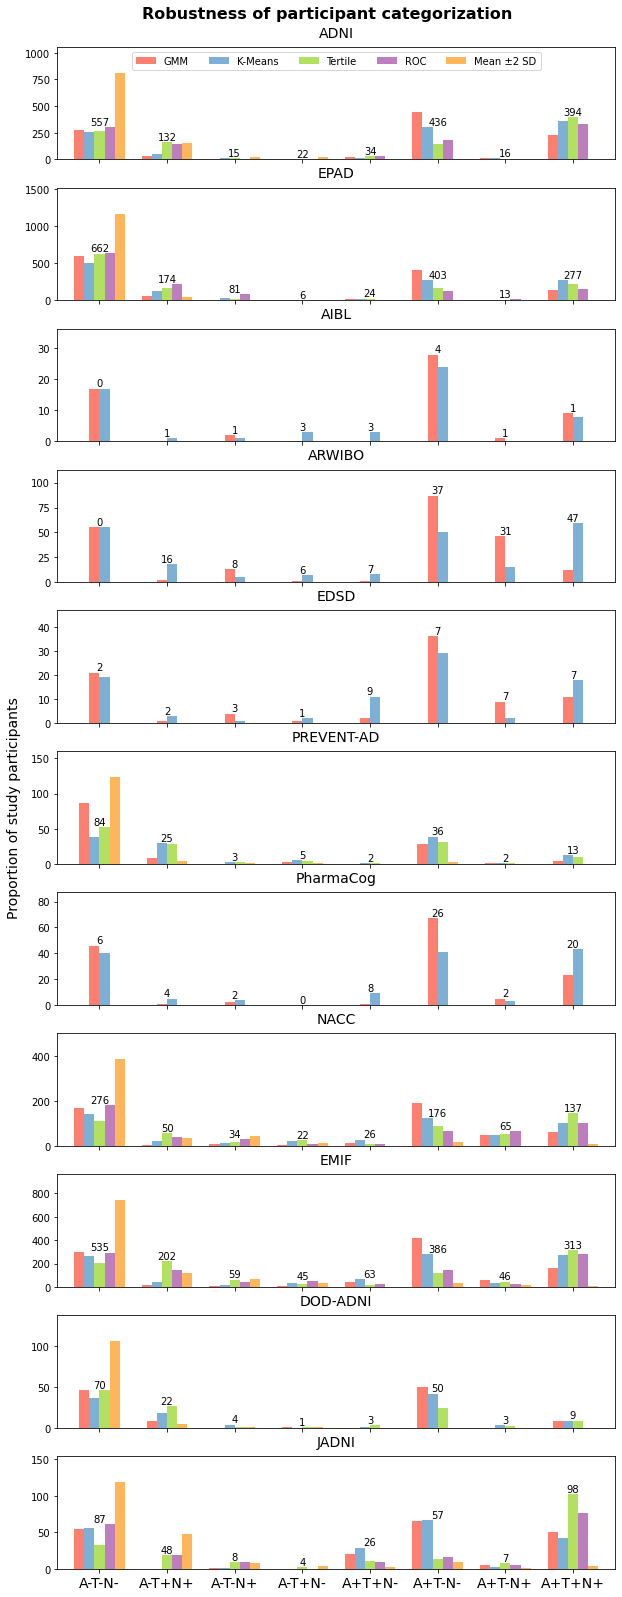

In [256]:
fig, axes = plt.subplots(11, sharex=True, figsize=(10, 28))
fig.subplots_adjust(hspace=0.25)
width = {'2': .3, '4': 0.6, '5': .75}
colors_ = ["#fd7f6f", "#7eb0d5", "#b2e061", "#bd7ebe", "#ffb55a"]
colors_dict = {method: color for color, method in zip(colors_, profiles_all.method.unique())}
fig.suptitle(f"Robustness of participant categorization", weight="bold", ha="center", fontsize=16, y=.9)

for i, coh in enumerate(profiles_all.index.unique()):
    current_cohort_ = profiles_all.loc[coh].copy()
    current_cohort_['Cohort'] = coh
    current_cohort_.rename(columns={'method': 'Method'}, inplace=True)
    current_cohort_.set_index('Method', inplace=True)
    current_cohort_ = current_cohort_.transpose()
    for ind in current_cohort_.index[:-1]:
        current_cohort_.loc[ind, 'delta'] = (max(current_cohort_.loc[ind]) - min(current_cohort_.loc[ind]))
    
    max_limit = current_cohort_.iloc[:-1].to_numpy().max()
    

    for x_pos, indd in enumerate(current_cohort_.index[:-1]):            

        if len(current_cohort_.columns[:-1])==5:
            position_ = max(current_cohort_.loc[indd, current_cohort_.columns[1:4]])

            axes[i].text(x_pos, position_, int(current_cohort_.loc[indd, 'delta']), ha='center', va='bottom')

        elif len(current_cohort_.columns[:-1])==2:
            position_ = max(current_cohort_.loc[indd, current_cohort_.columns[:]])
            axes[i].text(x_pos, position_, int(current_cohort_.loc[indd, 'delta']), ha='center', va='bottom')

        else:
            position_ = max(current_cohort_.loc[indd, current_cohort_.columns[1:3]])
            axes[i].text(x_pos, position_, int(current_cohort_.loc[indd, 'delta']), ha='center', va='bottom')


    current_cohort_[current_cohort_.columns[:-1]].iloc[:-1].plot(kind='bar', ax=axes[i], color=colors_dict, legend=False, 
                                   width=width[str(len(current_cohort_.columns[:-1]))])
    axes[i].set_title(coh, fontsize=14, pad=10)
    axes[i].tick_params(rotation=0, axis="x", which='major', labelsize=14)
    axes[i].set_ylim([0, max_limit+(max_limit*0.3)])

axes[5].set_ylabel('Number of study participants', fontsize=14, labelpad=10)
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles=handles, labels=labels,  loc='upper center', ncol=5)
    
# other legend 
# patches = list()            
# text_ = ['Num. - difference in participants between max. and min. method']
# patches.append(Line2D([0], [0], color='white'))
# axes[0].legend(handles=patches, labels=text_, loc='upper center', ncol=1)

# plt.savefig("bar_plot_atn_with_legend.png", dpi=300, bbox_inches='tight')

In [311]:
profiles_all.loc['ADNI']

,A-T-N-,A-T+N+,A-T-N+,A-T+N-,A+T+N-,A+T-N-,A+T-N+,A+T+N+,method
ADNI,275,28,5,2,25,443,12,227,GMM
ADNI,256,49,14,0,18,305,16,359,K-Means
ADNI,265,160,10,3,33,148,3,395,Tertile
ADNI,304,147,8,6,34,180,1,337,ROC
ADNI,813,154,20,22,0,7,0,1,Mean ±2 SD


In [396]:
for i in range(0, 1300, 400):print(i)

0
400
800
1200


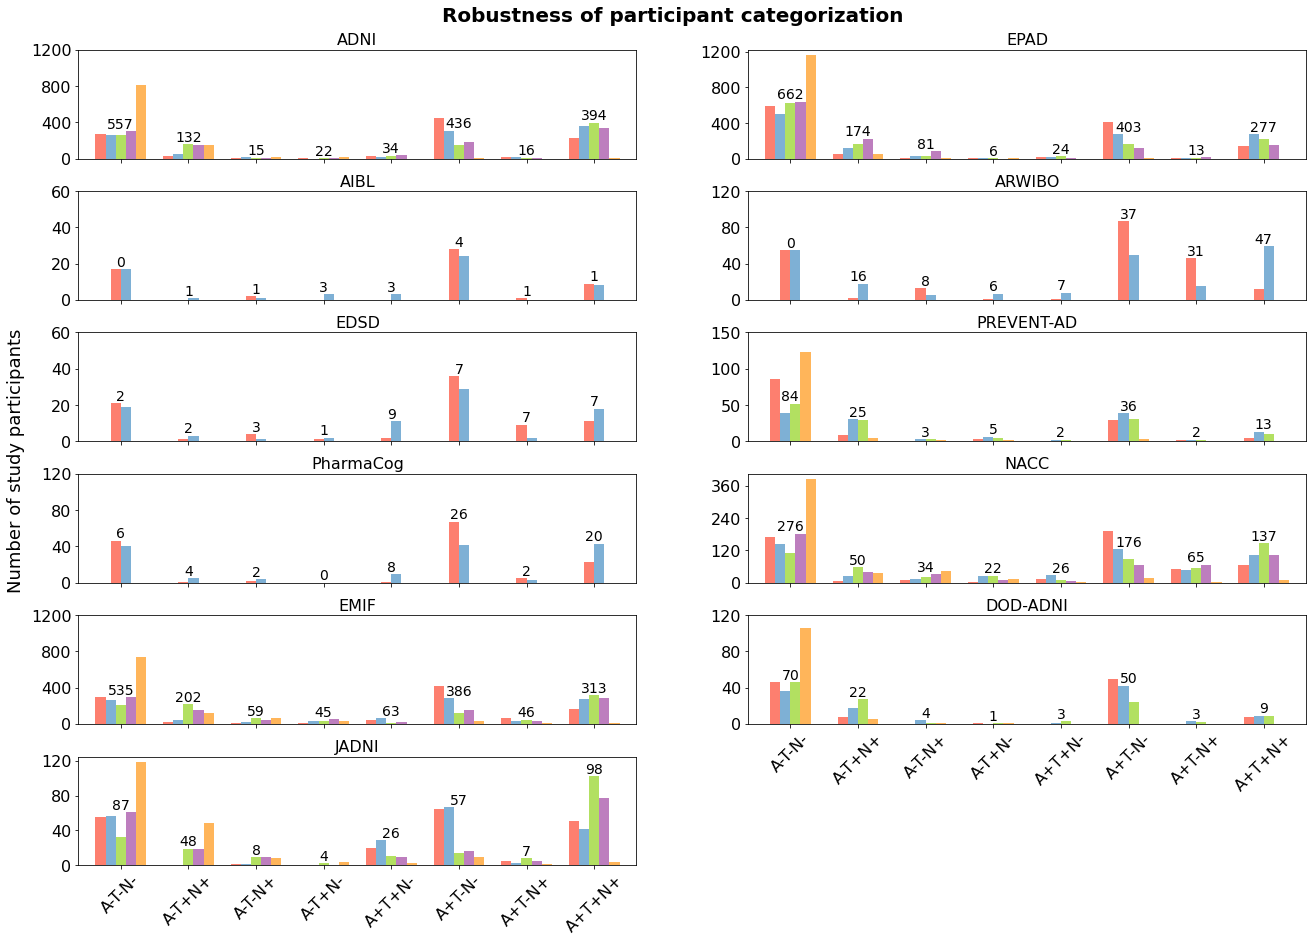

In [428]:
fig, axes = plt.subplots(6, 2, sharex=True, figsize=(22, 15))
fig.delaxes(axes[5, 1])
fig.subplots_adjust(hspace=0.3)
width = {'2': .3, '4': 0.6, '5': .75}
colors_ = ["#fd7f6f", "#7eb0d5", "#b2e061", "#bd7ebe", "#ffb55a"]
colors_dict = {method: color for color, method in zip(colors_, profiles_all.method.unique())}
fig.suptitle(f"Robustness of participant categorization", weight="bold", ha="center", fontsize=20, y=.92) 
row_, col_ = 0, 0

for i, coh in enumerate(profiles_all.index.unique()):
#     print(i)
    current_cohort_ = profiles_all.loc[coh].copy()
    current_cohort_['Cohort'] = coh
    current_cohort_.rename(columns={'method': 'Method'}, inplace=True)
    current_cohort_.set_index('Method', inplace=True)
    current_cohort_ = current_cohort_.transpose()
    for ind in current_cohort_.index[:-1]:
        current_cohort_.loc[ind, 'delta'] = (max(current_cohort_.loc[ind]) - min(current_cohort_.loc[ind]))
    
    max_limit = current_cohort_.iloc[:-1].to_numpy().max()
#     print(coh, max_limit)

    
    if i==0 or i%2==0:

        for x_pos, indd in enumerate(current_cohort_.index[:-1]):            

            if len(current_cohort_.columns[:-1])==5:
                position_ = max(current_cohort_.loc[indd, current_cohort_.columns[1:4]])

                axes[row_, col_].text(x_pos, position_, int(current_cohort_.loc[indd, 'delta']), ha='center', va='bottom', fontsize=14)

            elif len(current_cohort_.columns[:-1])==2:
                position_ = max(current_cohort_.loc[indd, current_cohort_.columns[:]])
                axes[row_, col_].text(x_pos, position_, int(current_cohort_.loc[indd, 'delta']), ha='center', va='bottom', fontsize=14)

            else:
                position_ = max(current_cohort_.loc[indd, current_cohort_.columns[1:3]])
                axes[row_, col_].text(x_pos, position_, int(current_cohort_.loc[indd, 'delta']), ha='center', va='bottom', fontsize=14)


        current_cohort_[current_cohort_.columns[:-1]].iloc[:-1].plot(kind='bar', ax=axes[row_, col_], color=colors_dict, legend=False, 
                                       width=width[str(len(current_cohort_.columns[:-1]))])
        axes[row_, col_].set_title(coh, fontsize=16, pad=5)
        axes[row_, col_].tick_params(rotation=45, axis="x", which='major', labelsize=16)
        axes[row_, col_].tick_params(rotation=0, axis="y", which='major', labelsize=16)
        if max_limit<50:
            axes[row_, col_].set_yticks(range(0, 70, 20))
            
        elif 50<max_limit<120:
            axes[row_, col_].set_yticks(range(0, 125, 40))
        
        elif 120<max_limit<150:
            axes[row_, col_].set_yticks(range(0, 160, 50))  
            
        elif 150<max_limit<400:
            axes[row_, col_].set_yticks(range(0, 420, 120))
            
        else:
            axes[row_, col_].set_yticks(range(0, 1300, 400))
#         axes[row_, col_].set_yticks(range(0, max_limit, int(max_limit/2)))
#         axes[row_, col_].set_ylim([0, max_limit+(max_limit*0.70)])
        
        col_+=1

        
        
    else:
        
        for x_pos, indd in enumerate(current_cohort_.index[:-1]):            
            
            if len(current_cohort_.columns[:-1])==5:
                position_ = max(current_cohort_.loc[indd, current_cohort_.columns[1:4]])

                axes[row_, col_].text(x_pos, position_, int(current_cohort_.loc[indd, 'delta']), ha='center', va='bottom', fontsize=14)

            elif len(current_cohort_.columns[:-1])==2:
                position_ = max(current_cohort_.loc[indd, current_cohort_.columns[:]])
                axes[row_, col_].text(x_pos, position_, int(current_cohort_.loc[indd, 'delta']), ha='center', va='bottom', fontsize=14)

            else:
                position_ = max(current_cohort_.loc[indd, current_cohort_.columns[1:3]])
                axes[row_, col_].text(x_pos, position_, int(current_cohort_.loc[indd, 'delta']), ha='center', va='bottom', fontsize=14)


        current_cohort_[current_cohort_.columns[:-1]].iloc[:-1].plot(kind='bar', ax=axes[row_, col_], color=colors_dict, legend=False, 
                                       width=width[str(len(current_cohort_.columns[:-1]))])


        axes[row_, col_].set_title(coh, fontsize=16, pad=5)
        axes[row_, col_].tick_params(rotation=45, axis="x", which='major', labelsize=16)
        axes[row_, col_].tick_params(rotation=0, axis="y", which='major', labelsize=16)
        if max_limit<50:
            axes[row_, col_].set_yticks(range(0, 70, 20))
            
        elif 50<max_limit<120:
            axes[row_, col_].set_yticks(range(0, 125, 40))
        
        elif 120<max_limit<150:
            axes[row_, col_].set_yticks(range(0, 160, 50))  
            
        elif 150<max_limit<400:
            axes[row_, col_].set_yticks(range(0, 420, 120))
            
        else:
            axes[row_, col_].set_yticks(range(0, 1300, 400))
        
        col_=0
        row_+=1

axes[4, 1].tick_params(labelbottom=True)
        
fig.text(0.08, 0.5, 'Number of study participants', va='center', rotation='vertical', fontsize=18)
# fig.supylabel('Number of study participants', fontsize=14, ha='center', va='center')
# handles, labels = axes[0].get_legend_handles_labels()
# axes[0].legend(handles=handles, labels=labels,  loc='upper center', ncol=5)
    
# other legend 
# patches = list()            
# text_ = ['Num. - difference in participants between max. and min. method']
# patches.append(Line2D([0], [0], color='white'))
# axes[0].legend(handles=patches, labels=text_, loc='upper center', ncol=1)

plt.savefig("bar_plot_atn_double_col_rotated_labels.png", dpi=300, bbox_inches='tight')

###  Read all cutoff tables

In [117]:
tables = [pd.read_csv(file, index_col=0, low_memory=False) for file in sorted(glob.glob('../cutoffs/' + "/*."+'csv'))]
methods = [file.split(".")[0] for file in sorted(os.listdir('../cutoffs/'))]

In [13]:
methods

['cutoffs_cohort_study',
 'gmm_baseline_cutoffs',
 'gmm_cutoffs',
 'km_cutoffs',
 'mean_std_cutoffs',
 'roc_cutoffs',
 'tertile_cutoffs']

In [14]:
# make a dictionary that contains all cutoff tables as a dataframe
cutoff_tables = dict()

for tab, meth in zip(tables, methods):
    cutoff_tables[meth] = tab

In [15]:
# select the relevant methods to plot
cutoffs = dict()

# methods_order = ['gmm_cutoffs', 'km_cutoffs', 'mean_std_cutoffs', 'tertile_cutoffs', 'roc_cutoffs', 'cutoffs_cohort_study']

for i in methods:
    if i not in ['gmm_baseline_cutoffs']:
        cutoffs[i] = cutoff_tables[i]

In [16]:
cutoffs['cutoffs_cohort_study'] = cutoffs['cutoffs_cohort_study'][~cutoffs['cutoffs_cohort_study'].index.isin(['EDSD', 'EMIF'])].dropna()

In [17]:
# convert values to float
for i in cutoffs['cutoffs_cohort_study'].columns:
    cutoffs['cutoffs_cohort_study'][i] = cutoffs['cutoffs_cohort_study'][i].astype(float)

In [18]:
for i in cutoffs:
    cutoffs[i]['method'] = i

In [19]:
#rename columns before combining the dataframes 
for i in cutoffs['km_cutoffs'].columns:
    cutoffs['km_cutoffs'].rename(columns={i: i.split('_')[0]}, inplace=True)

In [20]:
thresholds = pd.concat(cutoffs.values())

In [72]:
thresholds.loc['EPAD']

,A-beta 1-42 in CSF,pTau in CSF,tTau in CSF,method
EPAD,1034.92,27.74,306.69,gmm_cutoffs
EPAD,1030.74,19.84,223.56,km_cutoffs
EPAD,337.89,43.34,436.41,mean_std_cutoffs
EPAD,731.50,20.90,213.80,roc_cutoffs
EPAD,882.97,19.90,228.27,tertile_cutoffs


### Which method often results in lowest/highest thresholds?

In [381]:
trend_max = pd.DataFrame(index=thresholds.index.unique(), columns=thresholds.columns[:-1])
trend_min = pd.DataFrame(index=thresholds.index.unique(), columns=thresholds.columns[:-1])
heatmap_df_method = {i: pd.DataFrame(index=thresholds.index.unique(), columns=set(thresholds['method'].unique()).difference(['cutoffs_cohort_study'])) for i in thresholds.columns[:-1]}
heatmap_df_method_order = pd.DataFrame(index=thresholds.index.unique(), columns=set(thresholds['method'].unique()).difference(['cutoffs_cohort_study']))
# heatmap_df_csf = pd.DataFrame(index=thresholds.index.unique(), columns=set(thresholds['method'].unique()).difference(['cutoffs_cohort_study']))

In [382]:
# create a dictionary of dictionary where keys are CSF and values are dataframes
heatmaps = {i: pd.DataFrame(index=thresholds.index.unique(), 
            columns=set(thresholds['method'].unique()).difference(['cutoffs_cohort_study'])) 
            for i in thresholds.columns[:-1]}


for i in heatmaps: heatmaps[i].replace({np.nan: 0}, inplace=True)

In [383]:
cutoffs_five_method = thresholds[thresholds['method']!='cutoffs_cohort_study']

In [389]:
# Rank the methods that were feasible by 2  

for bioma__ in heatmap_df_method:
    
    for i in cutoffs_five_method.index: 
        for met in cutoffs_five_method.loc[i]['method'].to_list():
            
            heatmap_df_method[bioma__].loc[i, met] = 2

In [391]:
for i in cutoffs_five_method.index.unique():
    df = cutoffs_five_method.loc[i]
    
    for col in df.columns[:-1]:
        trend_max.loc[i, col] = df.loc[df[col]==df[col].max()]['method'].item()
        trend_min.loc[i, col] = df.loc[df[col]==df[col].min()]['method'].item()
        heatmap_df_method[col].loc[i, df.loc[df[col]==df[col].max()]['method'].item()] = 3 # maximum threshold
        heatmap_df_method[col].loc[i, df.loc[df[col]==df[col].min()]['method'].item()] = 1 # minimum threshold
        
        for num, met in zip(list(np.arange(1, 6)), cutoffs_five_method.loc[i].sort_values(by=col)['method'].to_list()):
            heatmaps[col].loc[i, met] = num # method that were not perform will remain 0

In [392]:
for i in heatmap_df_method:
    heatmap_df_method[i].rename(columns={'mean_std_cutoffs': 'Mean ±2 SD', 'gmm_cutoffs': 'GMM', 
                              'roc_cutoffs': 'ROC', 'km_cutoffs': 'K-Means', 
                              'tertile_cutoffs': 'Tertile'}, index={'NACC_ELISA': 'NACC ELISA', 
                              'NACC_XMAP': 'NACC XMAP', 'EMIF_ELISA': 'EMIF ELISA', 
                              'EMIF_XMAP': 'EMIF XMAP'}, inplace=True)
    
    heatmap_df_method[i] = heatmap_df_method[i].loc[['ADNI', 'EPAD', 'AIBL', 'ARWIBO', 'EDSD', 
            'PREVENT-AD', 'PharmaCog', 'NACC ELISA', 'EMIF ELISA', 'NACC XMAP', 'EMIF XMAP', 
            'DOD-ADNI', 'JADNI']]
    heatmap_df_method[i] = heatmap_df_method[i][['GMM', 'K-Means', 'Tertile', 'ROC', 'Mean ±2 SD']]

In [393]:
# heatmap_df_method['A-beta 1-42 in CSF']

In [394]:
# heatmap_df_method_order.replace({np.nan: 0}, inplace=True)

In [395]:
for i in heatmaps:
    heatmaps[i].rename(columns={'mean_std_cutoffs': 'Mean ±2 SD', 'gmm_cutoffs': 'GMM', 
                              'roc_cutoffs': 'ROC', 'km_cutoffs': 'K-Means', 
                              'tertile_cutoffs': 'Tertile'}, inplace=True)

A-beta 1-42 in CSF
pTau in CSF
tTau in CSF


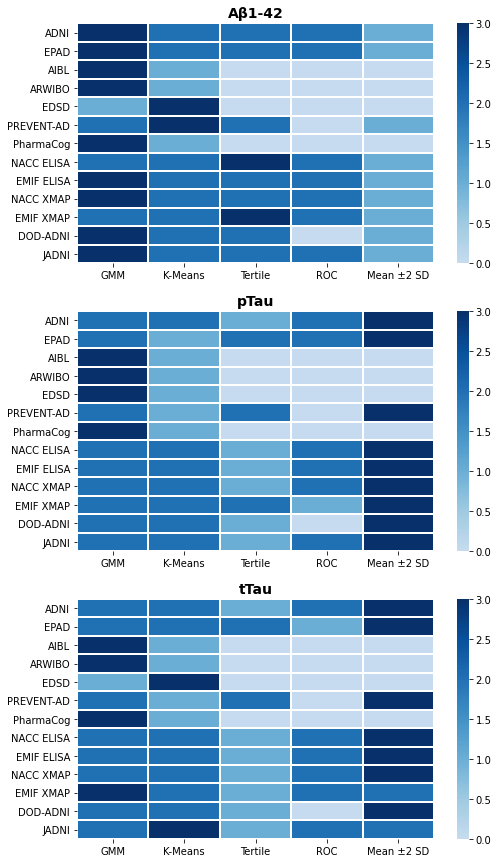

In [412]:
cmap=['#f2f7ff','#568ae3', '#0040a6']
# cmap = ['#f5f9fc', '#d0e1f0', '#abcae4', '#86b2d8', '#619bcc', '#3d84bf', '#316a9a']
csf_names = {'A-beta 1-42 in CSF': 'Aβ1-42', 'pTau in CSF': 'pTau', 'tTau in CSF': 'tTau'}

fig, axes = plt.subplots(3, 1, figsize=(8, 15))

for i, j in enumerate(heatmaps):
    print(j)
    sns.heatmap(heatmap_df_method[j].replace({np.nan: 0}), cmap='Blues', center=1, linewidths=1.5, ax=axes[i])
    axes[i].set_title(csf_names[j], weight="bold", fontsize=14)
    
plt.savefig("trend_methods.png", dpi=400, bbox_inches='tight')

A-beta 1-42 in CSF
pTau in CSF
tTau in CSF


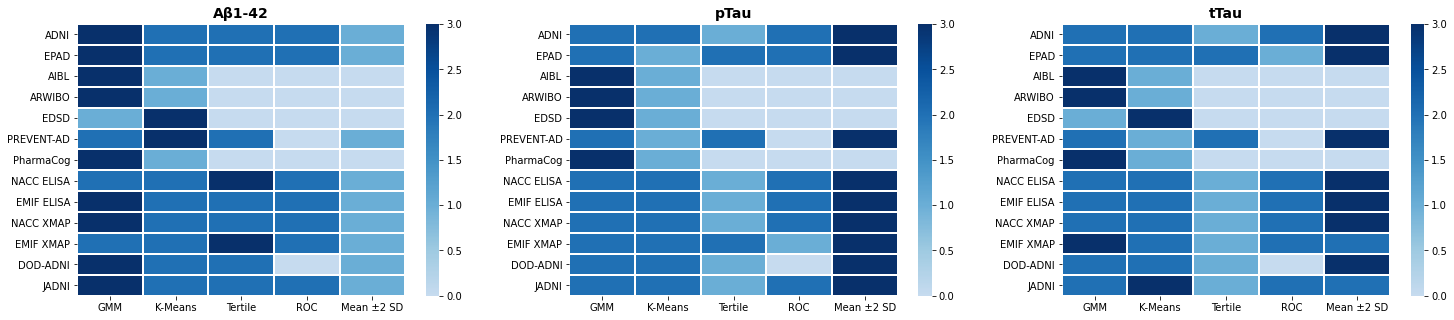

In [417]:
cmap=['#f2f7ff','#568ae3', '#0040a6']
# cmap = ['#f5f9fc', '#d0e1f0', '#abcae4', '#86b2d8', '#619bcc', '#3d84bf', '#316a9a']
csf_names = {'A-beta 1-42 in CSF': 'Aβ1-42', 'pTau in CSF': 'pTau', 'tTau in CSF': 'tTau'}

fig, axes = plt.subplots(1, 3, figsize=(25, 5))

for i, j in enumerate(heatmaps):
    print(j)
    sns.heatmap(heatmap_df_method[j].replace({np.nan: 0}), cmap='Blues', center=1, linewidths=1.5, ax=axes[i])
    axes[i].set_title(csf_names[j], weight="bold", fontsize=14)
    
plt.savefig("trend_methods_horizontal.png", dpi=400, bbox_inches='tight')

In [403]:
# # cmap=['#f2f7ff','#568ae3', '#0040a6']
# # cmap = ['#f5f9fc', '#d0e1f0', '#abcae4', '#86b2d8', '#619bcc', '#3d84bf', '#316a9a']
# csf_names = {'A-beta 1-42 in CSF': 'Aβ1-42', 'pTau in CSF': 'pTau', 'tTau in CSF': 'tTau'}

# fig, axes = plt.subplots(1, 3, figsize=(20, 4))

# for i, j in enumerate(heatmaps):
#     print(j)
#     sns.heatmap(heatmaps[j], cmap='Blues', center=1, linewidths=1.5, ax=axes[i])
#     axes[i].set_title(csf_names[j])
    
# # plt.savefig("trend_methods.png", dpi=400, bbox_inches='tight')

In [404]:
# # cmap=['#f2f7ff','#568ae3', '#0040a6']
# # cmap = ['#f5f9fc', '#d0e1f0', '#abcae4', '#86b2d8', '#619bcc', '#3d84bf', '#316a9a']
# csf_names = {'A-beta 1-42 in CSF': 'Aβ1-42', 'pTau in CSF': 'pTau', 'tTau in CSF': 'tTau'}

# fig, axes = plt.subplots(3, 1, figsize=(6, 15))

# for i, j in enumerate(heatmaps):
#     print(j)
#     sns.heatmap(heatmaps[j], cmap='Blues', center=1, linewidths=1.5, ax=axes[i])
#     axes[i].set_title(csf_names[j])
    
# # plt.savefig("trend_methods_test.png", dpi=400, bbox_inches='tight')

In [362]:
for i in trend_max.columns:
    print(i, Counter(trend_max[i]))

A-beta 1-42 in CSF Counter({'gmm_cutoffs': 9, 'km_cutoffs': 2, 'tertile_cutoffs': 2})
pTau in CSF Counter({'mean_std_cutoffs': 9, 'gmm_cutoffs': 4})
tTau in CSF Counter({'mean_std_cutoffs': 7, 'gmm_cutoffs': 4, 'km_cutoffs': 2})


In [144]:
for i in trend_min.columns:
    print(i, Counter(trend_min[i]))

A-beta 1-42 in CSF Counter({'mean_std_cutoffs': 9, 'km_cutoffs': 3, 'gmm_cutoffs': 1})
pTau in CSF Counter({'tertile_cutoffs': 6, 'km_cutoffs': 6, 'roc_cutoffs': 1})
tTau in CSF Counter({'tertile_cutoffs': 7, 'km_cutoffs': 4, 'roc_cutoffs': 1, 'gmm_cutoffs': 1})


In [104]:
trend_max

,A-beta 1-42 in CSF,pTau in CSF,tTau in CSF
ADNI,gmm_cutoffs,mean_std_cutoffs,mean_std_cutoffs
AIBL,gmm_cutoffs,gmm_cutoffs,gmm_cutoffs
DOD-ADNI,gmm_cutoffs,mean_std_cutoffs,mean_std_cutoffs
JADNI,gmm_cutoffs,mean_std_cutoffs,km_cutoffs
PharmaCog,gmm_cutoffs,gmm_cutoffs,gmm_cutoffs
EPAD,gmm_cutoffs,mean_std_cutoffs,mean_std_cutoffs
ARWIBO,gmm_cutoffs,gmm_cutoffs,gmm_cutoffs
EDSD,km_cutoffs,gmm_cutoffs,km_cutoffs
PREVENT-AD,km_cutoffs,mean_std_cutoffs,mean_std_cutoffs
NACC_ELISA,tertile_cutoffs,mean_std_cutoffs,mean_std_cutoffs


In [106]:
trend_min

,A-beta 1-42 in CSF,pTau in CSF,tTau in CSF
ADNI,mean_std_cutoffs,tertile_cutoffs,tertile_cutoffs
AIBL,km_cutoffs,km_cutoffs,km_cutoffs
DOD-ADNI,mean_std_cutoffs,tertile_cutoffs,tertile_cutoffs
JADNI,mean_std_cutoffs,tertile_cutoffs,tertile_cutoffs
PharmaCog,km_cutoffs,km_cutoffs,km_cutoffs
EPAD,mean_std_cutoffs,km_cutoffs,roc_cutoffs
ARWIBO,km_cutoffs,km_cutoffs,km_cutoffs
EDSD,gmm_cutoffs,km_cutoffs,gmm_cutoffs
PREVENT-AD,mean_std_cutoffs,km_cutoffs,km_cutoffs
NACC_ELISA,mean_std_cutoffs,tertile_cutoffs,tertile_cutoffs


In [105]:
heatmap_df

,mean_std_cutoffs,gmm_cutoffs,roc_cutoffs,km_cutoffs,tertile_cutoffs
ADNI,2,2,NaN,NaN,1
AIBL,NaN,2,NaN,1,NaN
DOD-ADNI,2,2,NaN,NaN,1
JADNI,2,2,NaN,2,1
PharmaCog,NaN,2,NaN,1,NaN
EPAD,2,2,1,1,NaN
ARWIBO,NaN,2,NaN,1,NaN
EDSD,NaN,1,NaN,2,NaN
PREVENT-AD,2,NaN,NaN,1,NaN
NACC_ELISA,2,NaN,NaN,NaN,1


In [66]:
thresholds.head()

,A-beta 1-42 in CSF,pTau in CSF,tTau in CSF,method
ADNI,980.0,21.8,245.0,cutoffs_cohort_study
AIBL,1054.0,213.0,21.3,cutoffs_cohort_study
DOD-ADNI,515.0,87.3,436.0,cutoffs_cohort_study
JADNI,333.0,45.0,93.0,cutoffs_cohort_study
PharmaCog,550.0,61.0,190.0,cutoffs_cohort_study


### Plot the thresholds 

In [28]:
for i in thresholds.columns[:-1]: 
    thresholds.rename(columns={i: i.split(" in")[0]}, inplace=True)
    
thresholds.rename(columns={'A-beta 1-42': 'Aβ1-42'}, inplace=True)

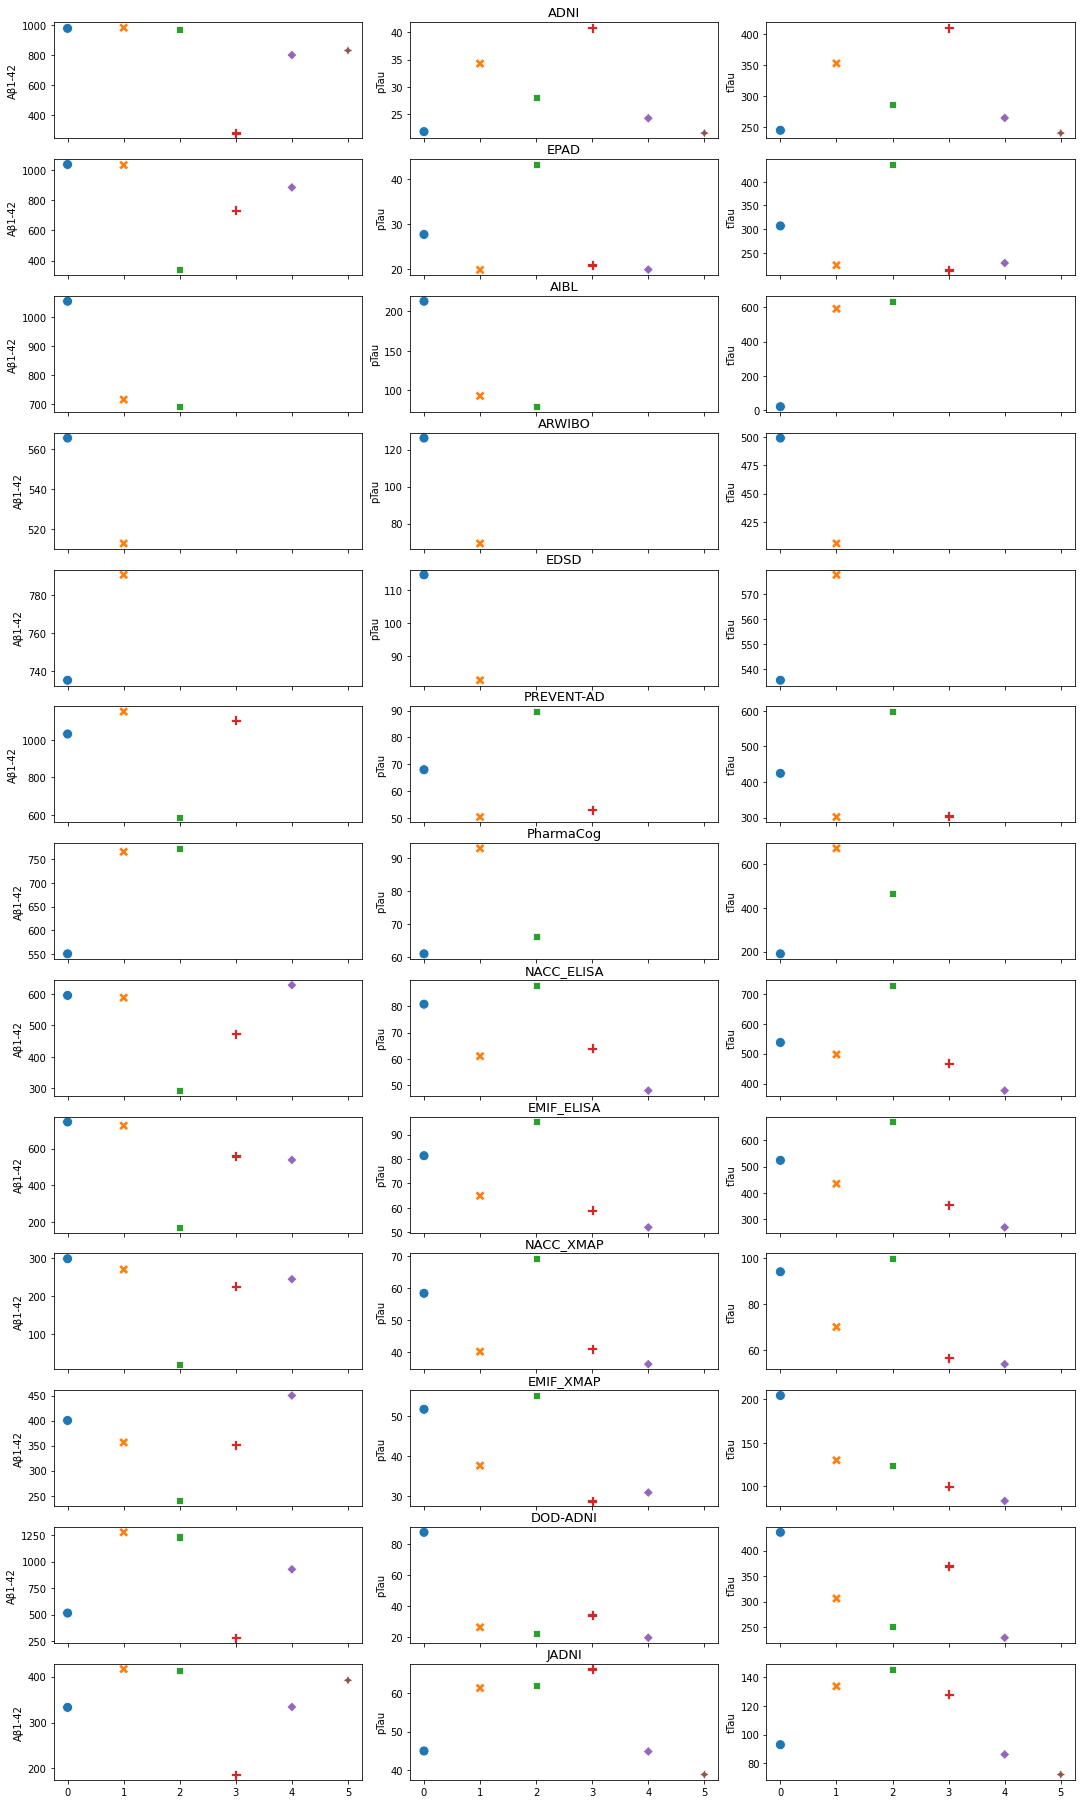

In [30]:
cohort_order= ['ADNI', 'EPAD', 'AIBL', 'ARWIBO', 'EDSD', 'PREVENT-AD', 'PharmaCog',
       'NACC_ELISA', 'EMIF_ELISA', 'NACC_XMAP',
       'EMIF_XMAP', 'DOD-ADNI', 'JADNI']

fig, axes = plt.subplots(13, 3, sharex=True, figsize=(15, 25))
fig.tight_layout()
# fig.subplots_adjust(hspace=0.7)
i=0

for ind in cohort_order:
    
    for bioma, location in zip(thresholds.columns[:-1], range(3)):

        sns.scatterplot(x=range(len(thresholds.loc[ind, bioma])), y=thresholds.loc[ind, bioma], hue=thresholds.loc[ind, 'method'], 
                        ax=axes[i, location], legend=False, style=thresholds.loc[ind, 'method'], s=100)
        
        axes[i, location].grid(False)
        axes[i, location].set_xlabel('')
#         axes[i, location].set_ylabel('')
#         axes[i, location].set_title(bioma, fontsize=12)
        axes[i, 1].set_title(ind, fontsize=13)
    
    i+=1
    
# plt.savefig("thresholds.png", dpi=400, bbox_inches='tight')

['cutoffs_cohort_study', 'gmm_cutoffs', 'km_cutoffs', 'mean_std_cutoffs', 'roc_cutoffs', 'tertile_cutoffs']


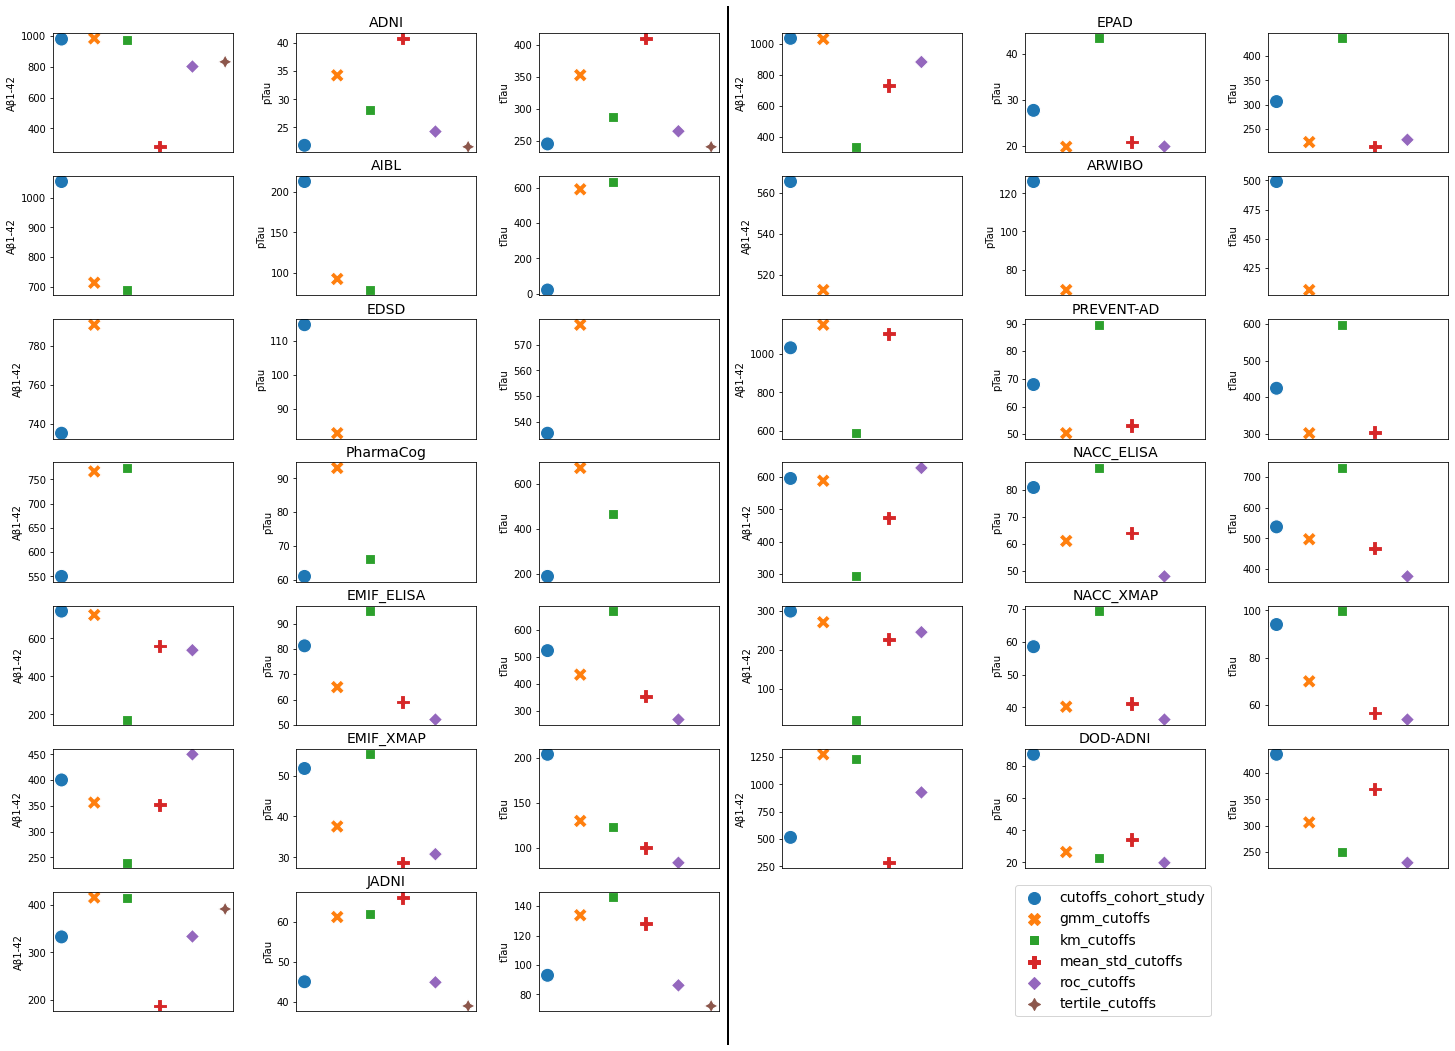

In [68]:
cohort_order= ['ADNI', 'EPAD', 'AIBL', 'ARWIBO', 'EDSD', 'PREVENT-AD', 'PharmaCog',
       'NACC_ELISA', 'EMIF_ELISA', 'NACC_XMAP',
       'EMIF_XMAP', 'DOD-ADNI', 'JADNI']

fig, axes = plt.subplots(7, 6, sharex=True, figsize=(25, 18))
fig.subplots_adjust(hspace=.2, wspace=.35)
# fig.tight_layout()
i=0
flag=1


method_names = {'cutoffs_cohort_study': 'Study-suggested', 'gmm_baseline_cutoffs': 'GMM baseline model', 
     'km_cutoffs': 'K-Means', 'mean_std_cutoffs': 'Mean ± SD', 
     'roc_cutoffs': 'ROC', 'tertile_cutoffs': 'Tertile', 'gmm_cutoffs': 'GMM'}

for ind in cohort_order:
    
    if flag==1:
        
        for bioma, location in zip(thresholds.columns[:-1], range(3)):

            sns.scatterplot(x=range(len(thresholds.loc[ind, bioma])), y=thresholds.loc[ind, bioma], hue=thresholds.loc[ind, 'method'], 
                            ax=axes[i, location], style=thresholds.loc[ind, 'method'], s=200)

            axes[i, location].grid(False)
            axes[i, location].set_xlabel('')
#             axes[i, location].set_ylabel('')
            axes[i, location].set_xticks([])
            handles, labels = axes[i, location].get_legend_handles_labels()
            axes[i, location].legend().remove()
            axes[i, 1].set_title(ind, fontsize=14)

        flag+=1
        
        line = plt.Line2D((.5, .5), (.1, .9), color='black', linewidth=2)
        
    else:
        
        for bioma, location in zip(thresholds.columns[:-1], range(3, 6)):

            sns.scatterplot(x=range(len(thresholds.loc[ind, bioma])), y=thresholds.loc[ind, bioma], hue=thresholds.loc[ind, 'method'], 
                            ax=axes[i, location], legend=False, style=thresholds.loc[ind, 'method'], s=200)

            axes[i, location].grid(False)
            axes[i, location].set_xlabel('')
#             axes[i, location].set_ylabel('')
            axes[i, 4].set_title(ind, fontsize=14)

        flag=1
        i+=1

for i in range(3, 6):
    fig.delaxes(axes[6, i])
    
print(labels)

    
plt.legend(handles, labels, loc='lower right', bbox_to_anchor=(3.77, -0.1), fontsize=14, markerscale=2)
fig.add_artist(line)

# fig.subplots_adjust(wspace=2)
    
# plt.savefig("thresholds_2.png", dpi=400, bbox_inches='tight')